Data Science + Social Justice<br>
Word Embeddings <br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

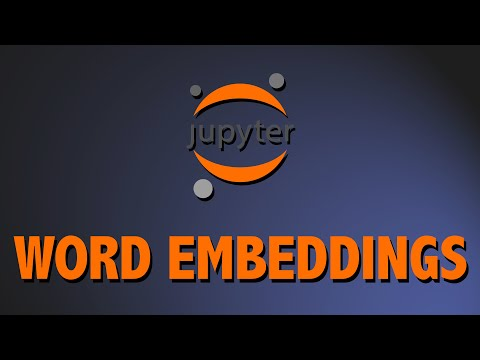

In [1]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('JrVHMfgXoAE', width=640, height=360)

# Word Embeddings

Today, we'll have a look at word embeddings using Gensim's `word2vec` method. 

The goal of word vector embedding models is to learn dense, numerical vector representations for each term in a corpus vocabulary. If successful, the vectors for each term encode information about the meaning or concept the term represents, as well as the relationship between it and other terms in the vocabulary. Word vector models are  fully unsupervised: they learn all of these meanings and relationships without any advance knowledge. Read [this post](https://tomvannuenen.medium.com/analyzing-reddit-communities-with-python-part-6-word-embeddings-f92bba876d60) I wrote for an introduction on Word Embeddings, or see [this video](
https://www.youtube.com/watch?v=5PL0TmQhItY).

After working through today's notebook, you'll be able to:

1. Use Gensim's word2vec method to create word vectors for a corpus;
2. Use these word vectors to reflect on implicit binaries and normativities in your data;
3. Visualize topic models using K-means clustering.

In [2]:
!ls

4-1 Word Embeddings.ipynb 4-2 Language Biases.ipynb


As we will be considering the language biases in the next notebook, we will use the comments of our subreddit this time. The thinking behind this is that this data will be derived from more people, and include more evaluative statements (after all, comments on r/amitheasshole generally evaluate the original posts).

In [3]:
import os
# We include two ../ because we want to go two levels up in the file structure
os.chdir("../../Data")

In [64]:
import pandas as pd 

df = pd.read_csv('aita_com_top.csv')
df.head(3)

,idint,idstr,created,author,parent,submission,body,score,subreddit,distinguish,textlen
0,27068149210,t1_cfnodlm,1393275432,swallowedfilth,t3_1ytr72,t3_1ytr72,Seems like you have a genuine reason to be ups...,33.0,AmItheAsshole,NaN,210.0
1,27068245493,t1_cfnqfw5,1393279437,RoonilaWazlib,t3_1ytxov,t3_1ytxov,There is nothing wrong with your original comm...,47.0,AmItheAsshole,NaN,561.0
2,27068297463,t1_cfnrjzr,1393281730,flignir,t3_1yu29c,t3_1yu29c,Yep. You're the asshole. If you want to make...,116.0,AmItheAsshole,NaN,1118.0


In [65]:
df = df[~df['body'].isin(['[removed]', '[deleted]' ])].dropna(subset=['body'])
df = df[df['body'].str.len()>=15]
len(df)

295671

In [8]:
import spacy
nlp = spacy.load('en_core_web_sm')
from gensim.models.phrases import Phrases, Phraser

def clean(token):
    """
    helper function to eliminate tokens
    that are pure punctuation, whitespace, or digits
    """
    return token.is_punct or token.is_space or token.is_digit

def line_read(df):
    """
    generator function to read in text from df
    and get rid of line breaks in the text
    """    
    for text in df.body:
        yield text.replace('\n', '')

def preprocess(df, allowed_postags=['NOUN', 'ADJ']):
    for parsed in nlp.pipe(line_read(df), batch_size=1000, disable=["tok2vec", "ner"]):
        lemmas = [token.lemma_.lower() if token.lemma_ != '-PRON-' else token.lower_ 
                    for token in parsed if not clean(token)]
        lemmas_c = [l for l in lemmas if not l in ["'s",  "’s", "’"] and not l in allowed_postags]
        nostops = [term for term in lemmas_c if term not in spacy.lang.en.stop_words.STOP_WORDS]
        yield nostops

In [11]:
lemmas = [line for line in preprocess(df)]

In [12]:
# create bigram and trigram models
bigram = Phrases(lemmas, min_count=20, threshold=300)
trigram = Phrases(bigram[lemmas], min_count=20, threshold=100)  
bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)

def make_bigrams(texts):
    return [bigram_phraser[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_phraser[bigram_phraser[doc]] for doc in texts]

# Form trigrams
trigrams = make_trigrams(lemmas)


In [13]:
len(trigrams)

298952

Let's save the data to JSON.

In [14]:
import json

with open('aita_com_top_lemmas.json', 'w') as write:
    json.dump(trigrams, write)
    
# Opening the same file works as follows:
#with open("aita_com_top_lemmas.json") as f:
#    trigrams = json.load(f)



## Word2Vec

Let's create our word embeddings model. 

While last week's LDA method was focused on finding topics in a collection of documents (or in our case, submissions), word embeddings modeling focuses on individual words, and learning a vector representation of these words.

The input here is a text corpus split up in sentences – in word embeddings, there is no concept of "documents". The model's output is a set of "vectors" (one for each word) in N dimensions. Think of these vectors as "features", capturing latent meaning.

This model allows us to group the vectors of similar words together in vectorspace. We can then reduce the dimensionality to visualize the results in a way humans can understand (such as in a 2-dimensional space), or to perform linear algebra in order to find out to what extent words are related.

Word2Vec is one example of a word embeddings model. It learns by taking words and their contexts (e.g. sentences) into account, and can then try to predict other words. Given enough data, usage and contexts, word2vec can make accurate guesses about a word’s meaning based on its appearances. Those guesses can be used to establish a word’s association with other words (e.g. “man” is to “boy” what “woman” is to “girl”), or cluster documents and classify them by topic.

We now instantiate and train our Word2Vec model, using the parameters below.

In [16]:
from gensim.models import Word2Vec
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores you have at your disposal
num_features = 300        # Word vector dimensionality (how many features each word will be given)
min_word_count = 10        # Minimum word count to be taken into account
num_workers = cores       # Number of threads to run in parallel (equal to your amount of cores)
context = 5               # Context window size
downsampling = 1e-2       # Downsample setting for frequent words
seed_n = 1                # Seed for the random number generator (to create reproducible results) 
sg_n = 1                  # Skip-gram = 1, CBOW = 0
epochs = 20

model = Word2Vec(trigrams, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, seed=seed_n, sg=sg_n)

In [17]:
model.train(trigrams, total_examples=model.corpus_count, epochs=10)        

(55430230, 56925570)

That was it! We have a Word Embeddings model now.

In [18]:
model.save('aita_pos.emb')

In [19]:
from gensim.models import Word2Vec

model = Word2Vec.load('aita_pos.emb')

How many terms are in our vocabulary?

In [20]:
print('{:,} terms in the vocabulary.'.format(len(model.wv.vocab)))

14,743 terms in the vocabulary.


Let's take a peek at the word vectors our model has learned. We'll create a pandas DataFrame with the terms as the row labels, and the 100 dimensions of the word vector model as the columns.



In [21]:
import pandas as pd 

# build a list of the terms, integer indices,
# and term counts from the model model vocabulary
ordered_vocab = [(term, voc.index, voc.count)
                 for term, voc in model.wv.vocab.items()]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda x: (x[1]), reverse=False)

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the model vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(model.wv.vectors[term_indices, :], index=ordered_terms)

word_vectors

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
like,0.003286,-0.007494,-0.147123,0.123483,-0.056072,0.058049,0.013022,0.158125,-0.007073,0.009290,...,0.159610,0.016756,-0.031474,-0.164225,-0.134622,0.051364,-0.062037,-0.050602,-0.115816,-0.008655
want,-0.005547,-0.089374,-0.013141,0.097411,0.002872,0.239803,-0.077381,-0.039128,0.089009,0.061182,...,0.157533,-0.115733,-0.100982,-0.102517,0.116962,-0.057642,0.065103,-0.104457,0.019822,-0.081552
think,-0.005200,-0.116237,0.080569,0.082765,-0.197267,0.034598,-0.018026,-0.046789,0.184394,0.098455,...,0.113719,-0.015441,-0.078982,-0.020964,-0.061254,-0.059121,-0.040031,0.044172,-0.158582,-0.084719
people,0.126567,-0.063290,-0.110040,0.056494,-0.125584,0.187200,0.240622,-0.131200,0.100724,-0.014458,...,-0.129718,-0.068000,0.004012,0.079462,-0.071934,0.042839,-0.039635,-0.155984,0.015564,0.003095
know,0.055760,-0.300612,-0.124926,0.107720,0.014657,-0.049456,-0.063464,0.113465,-0.002768,0.102192,...,0.150713,-0.152397,0.028181,0.037906,-0.093143,0.040190,0.132152,-0.011406,-0.040110,-0.020255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
^^^^automod,0.411978,-0.330548,0.297929,-0.205078,-0.121140,0.348723,0.018697,0.176521,0.271130,0.239600,...,-0.097008,0.125876,0.072148,-0.224764,0.130283,-0.078114,0.218433,0.017585,0.036123,0.284987
11-year,0.195020,-0.399221,0.119103,0.160014,-0.093939,0.099475,0.030393,0.197315,0.022684,-0.145399,...,0.085824,0.043822,-0.048293,0.086684,-0.058158,-0.020609,0.174855,-0.020847,0.018516,0.063778
isaac,0.076897,-0.056821,0.327092,-0.093162,0.126998,0.031792,0.175220,-0.034337,0.063659,-0.078537,...,0.048989,-0.233318,-0.004307,-0.068612,-0.340771,-0.042872,0.001699,-0.190380,-0.139138,-0.069873
fallon,0.194309,-0.208630,0.158415,0.275024,0.163640,-0.040220,-0.057814,-0.005054,0.385989,-0.031624,...,-0.182810,-0.060052,0.106437,-0.113720,0.029818,-0.273814,0.131780,-0.216476,0.059165,-0.050584


### Getting related terms

With the information in our word embeddings model, we can try to find similarities between words that interest us (i.e. words that have a similar vector). Let's create a function that retrieves related terms to some input.

In [22]:
def get_related_terms(token, topn=20):
    """
    look up the topn most similar terms to token and print them as a formatted list
    """

    for word, similarity in model.most_similar(positive=[token], topn=topn):
        print(word, round(similarity, 3))

In [23]:
get_related_terms('asshole')

assholeishness 0.53
ta 0.516
nahyou’re 0.502
fuckwad 0.49
esh.your 0.484
ytfa 0.482
this:>i 0.478
esh.i 0.477
ytais 0.474
shp- 0.473
redflag 0.468
esh.you're 0.468
here**|**esh****no_hole_here**|**nah****not 0.467
ja 0.465
party_|**yta**|you're_hole 0.458
ytain 0.457
resounding 0.456
party_|**nta****everyone_sucks 0.453
info**|**info**#[click 0.449
esh.the 0.444


/var/folders/fp/m5lgnjn12xqf6210mmfgzfh80000gn/T/ipykernel_11260/422679264.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  for word, similarity in model.most_similar(positive=[token], topn=topn):


### Word algebra

Word algebra, also known as analogy completion, means doing math with words (like the famous example "king - man + woman = queen"). The core idea is that once words are represented as numerical vectors, you can do math with them. The mathematical procedure works as follows:

1. Provide a set of words or phrases you want to add or subtract.
2. Look up the vectors that represent those terms in the word vector model.
3. Add and subtract those vectors to produce a new, combined vector.
4. Look up the most similar vector(s) to this new, combined vector via cosine similarity.
5. Return the word(s) associated with the similar vector(s).

Let's try it out. We'll create a function that does this for us.

In [24]:
def word_algebra(add=[], subtract=[], topn=10):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = model.wv.most_similar(positive=add, negative=subtract, topn=topn)
    
    for term, similarity in answers:
        print(term)

In [39]:
word_algebra(add=['men', 'dating'])

man
women
19-year
woman
okcupid
5’4
date
cisgender
transman
generalise


In [26]:
word_algebra(add=['women', 'dating'])

transman
cisgender
androgynous
woman
libidos
erotica
date
fetishization
5’4
objectification


## K-means clustering
One convenience of word embeddings is that we can cluster them using, for instance, K-Means clustering. 

K-Means clustering aims to partition N observations into K clusters in which each observation belongs to the cluster with the nearest mean (called the "cluster centre"), which serves as a prototype of the cluster.

Since our words are all represented as vectors, applying K-Means is easy to do since the clustering algorithm will simply look at differences between vectors (and centers).

In [27]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from sklearn.manifold import TSNE

def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    return kmeans_clustering.cluster_centers_, idx;

In [28]:
Z = model.wv.syn0 # The syn0 array essentially holds raw word-vectors

/var/folders/fp/m5lgnjn12xqf6210mmfgzfh80000gn/T/ipykernel_11260/2526680361.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  Z = model.wv.syn0 # The syn0 array essentially holds raw word-vectors


In [29]:
centers, clusters = clustering_on_wordvecs(Z, 20);
centroid_map = dict(zip(model.wv.index2word, clusters));

Next, we get words in each cluster that are closest to the cluster center. To do this, we initialize a KDTree on the word vectors, and query it for the Top K words on each cluster center. Using the Index 2 word dictionary, we than correspond each word vector back to it’s original word representation and add them to a dataframe for easier printing.

In [30]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
    # Use closest points for each cluster center to query closest 20 points to it
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
    # Query Word Index  for each position in the above array, and added to a Dictionary
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    # Create DataFrame from dictionary
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df

Let’s get the top words and print the first 20 in each cluster:

In [31]:
import numpy as np

top_words = get_top_words(model.wv.index2word, 5000, centers, Z);

In [32]:
top_words[:30]

,Cluster #0,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11,Cluster #12,Cluster #13,Cluster #14,Cluster #15,Cluster #16,Cluster #17,Cluster #18,Cluster #19
1,nta.in,ytagrow,sandal,ytagrow,ytagrow,ytagrow,nta.why,ytagrow,ytagrow,ytagrow,intensifie,hijack,shp-,ytagrow,burritos,intensifie,nta.so,ntawho,⢠,ytagrow
2,intensifie,ntaplease,ytagrow,whataboutism,ntaplease,nta.so,ytagrow,nta.so,ntaeveryone,nta--,esh.it,ntawow,brandnewsentence,ntaplease,patty,ytagrow,whataboutism,ntaplease,⠃,ntaare
3,portugal,nta.so,ooof,ooof,nta.so,ntaeven,ytathey,nta.when,whataboutism,ytahave,ntaplease,ytain,iamverybadass,nta.so,spinach,lmaooo,ailment,intensifie,⡀,ntaeveryone
4,britain,lmaooo,ruler,ntaeveryone,ntalet,ntawhen,ntaits,ntaeven,nta.in,ytaget,ytagrow,updoot,ytagrow,ntaeveryone,cauliflower,^^^,ytagrow,😑,⡟,ntaplease
5,brits,ntaeveryone,ntaeven,nta.so,think,ntawhile,ytahave,time,nta.so,nta.why,nta.when,ytayeah,lmaooo,esh.it,lentil,ntaplease,nta.a,ytagrow,wikitextbot,ntaits
6,iran,think,ntaplease,shp-,ntaeven,think,nta.first,ntaplease,emancipation,ntaeven,ytaget,ntaplease,rareinsult,ytais,yta.as,shp-,anemia,eshwhy,⠋,^^^
7,funnily,shp-,ty,think,ooof,ntaeveryone,ntalet,nta.honestly,ntaeven,yale,ntawho,hijacking,nothingeverhappen,ytano,pesto,brandnewsentence,radiation,esh.it,⠁,ntawhen
8,iceland,know,nta.why,lmaooo,thing,know,nta.people,know,shp-,ntaits,eshwhy,nta.first,unsubbe,ytai’m,gobble,rareinsult,compromised,^^^,⣄,esh.if
9,republicans,ytahonestly,slick,ntaeven,know,nta.first,stbx,intensifie,think,eshwhy,ntaits,ntamaybe,stickie,esh.if,breadstick,oooooh,congenital,ntaeven,index)#[click,ytain
10,tourism,nta.why,intensifie,ytano,nta.why,esh.if,ntawho,ntawho,ntain,js,ntaeven,^^^,ntaplease,think,seasoning,nta.so,residual,oooooh,rulebook](https://www.reddit.com,ntafor


# T-SNE

The word embeddings made by the model can be visualised by reducing dimensionality of the words to 2 dimensions using tSNE.

T-Distributed Stochastic Neighbor Embedding, or t-SNE, is a dimensionality reduction technique to assist with visualizing high-dimensional datasets. It attempts to map high-dimensional data onto a low two- or three-dimensional representation. It tries to keep the relative distances between points as closely as possible in both high-dimensional and low-dimensional space.

Visualisations can be used to notice semantic and syntactic trends in the data.

In [33]:
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.manifold import TSNE

tsne_input = word_vectors.drop(spacy.lang.en.stop_words.STOP_WORDS, errors=u'ignore')
tsne_input = tsne_input.head(5000)

In [34]:
tsne_input

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
like,0.003286,-0.007494,-0.147123,0.123483,-0.056072,0.058049,0.013022,0.158125,-0.007073,0.009290,...,0.159610,0.016756,-0.031474,-0.164225,-0.134622,0.051364,-0.062037,-0.050602,-0.115816,-0.008655
want,-0.005547,-0.089374,-0.013141,0.097411,0.002872,0.239803,-0.077381,-0.039128,0.089009,0.061182,...,0.157533,-0.115733,-0.100982,-0.102517,0.116962,-0.057642,0.065103,-0.104457,0.019822,-0.081552
think,-0.005200,-0.116237,0.080569,0.082765,-0.197267,0.034598,-0.018026,-0.046789,0.184394,0.098455,...,0.113719,-0.015441,-0.078982,-0.020964,-0.061254,-0.059121,-0.040031,0.044172,-0.158582,-0.084719
people,0.126567,-0.063290,-0.110040,0.056494,-0.125584,0.187200,0.240622,-0.131200,0.100724,-0.014458,...,-0.129718,-0.068000,0.004012,0.079462,-0.071934,0.042839,-0.039635,-0.155984,0.015564,0.003095
know,0.055760,-0.300612,-0.124926,0.107720,0.014657,-0.049456,-0.063464,0.113465,-0.002768,0.102192,...,0.150713,-0.152397,0.028181,0.037906,-0.093143,0.040190,0.132152,-0.011406,-0.040110,-0.020255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
misgendere,-0.164051,0.198610,0.162844,0.201493,0.158212,-0.376215,0.048709,0.251407,-0.353008,0.036878,...,0.274457,0.072877,0.277319,0.275074,-0.425331,-0.006246,-0.042595,0.211007,-0.139434,-0.148406
thumb,0.204103,-0.096530,0.039428,-0.078475,0.021367,0.644217,0.045432,0.094629,0.043700,-0.076669,...,0.117751,0.190450,-0.103897,0.233605,-0.025300,-0.086524,-0.072426,-0.099952,0.201942,0.316623
casserole,-0.316518,-0.105873,-0.201930,0.137536,0.168988,0.177842,-0.289418,0.182917,-0.126963,0.130097,...,-0.241175,-0.161252,-0.220530,-0.217868,0.212312,0.138025,-0.488096,-0.401396,-0.447956,0.394083
barge,0.151498,-0.320314,0.108232,-0.048431,-0.121115,0.082168,0.041427,0.415725,-0.081472,0.463492,...,0.282469,0.058173,-0.276294,0.187091,0.243969,-0.152801,-0.135039,0.372008,-0.178531,-0.232597


In [35]:
# Create some filepaths
tsne_filepath = 'tsne_model'
tsne_vectors_filepath = 'tsne_vectors.npy'

In [36]:
import pickle

if 1 == 1:
    
    tsne = TSNE()
    tsne_vectors = tsne.fit_transform(tsne_input.values)
    
    with open(tsne_filepath, 'wb') as f:
        pickle.dump(tsne, f)

    pd.np.save(tsne_vectors_filepath, tsne_vectors)
    
with open(tsne_filepath, 'rb') as f:
    tsne = pickle.load(f)
    
tsne_vectors = pd.np.load(tsne_vectors_filepath)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(tsne_input.index),
                            columns=[u'x_coord', u'y_coord'])

/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/fp/m5lgnjn12xqf6210mmfgzfh80000gn/T/ipykernel_11260/4028228726.py:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.save(tsne_vectors_filepath, tsne_vectors)
/var/folders/fp/m5lgnjn12xqf6210mmfgzfh80000gn/T/ipykernel_11260/4028228726.py:16: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  tsne_vectors = pd.np.load(tsne_vectors_filepath)


In [37]:
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

output_notebook()
bokeh.io.output_notebook()


Loading BokehJS ...

Loading BokehJS ...

In [38]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title='t-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800)

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = '@index') )

# draw the words as circles on the plot
tsne_plot.circle('x_coord', 'y_coord', source=plot_data,
                 color='blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color='black')

# configure visual elements of the plot
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot)

# Reflection: the hermeneutics of word embeddings

“In vector space, identities and differences change in nature. Similarity and belonging no longer rely on resemblance or a common genesis but on measures of proximity or distance, on flat loci that run as vectors through the space.” (Dourish 2018: 73-4)

As we've seen, word embeddings are essentially a set of vectors. We should reflect on this. What is vectorization? It is reducing linguistic complexity. Or rather, it produces a common space that juxtaposes and mixes complex localized realities. Anything can be turned into a vector operation, but what do we lose when doing so? 